In [100]:
import datasets
from datasets import Dataset, DatasetDict
import pandas as pd
import transformers
from sklearn import preprocessing
from  matplotlib import  pyplot as plt

In [101]:
train=pd.read_csv('data/SMS_train.csv',dtype={'Message_body':str,'Label':str} ,encoding='cp1252').rename(columns={'Label':'label', 'Message_body':'text'}).reset_index(drop=True)
test=pd.read_csv('data/SMS_test.csv',dtype={'Message_body':str,'Spam or not spam':str} , encoding='cp1252').rename(columns={'Label':'label' , 'Message_body':'text'}).reset_index(drop=True)

In [103]:
del train['S. No.']
train.head()


,text,label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [104]:
train.dropna(inplace= True)

In [105]:
preprc = preprocessing.LabelEncoder()
train['label'] = preprc.fit_transform(train['label'])
test['label'] = preprc.fit_transform(test['label'])

In [106]:
train.head()

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1


<Axes: title={'center': 'balance  of  labels'}, ylabel='count'>

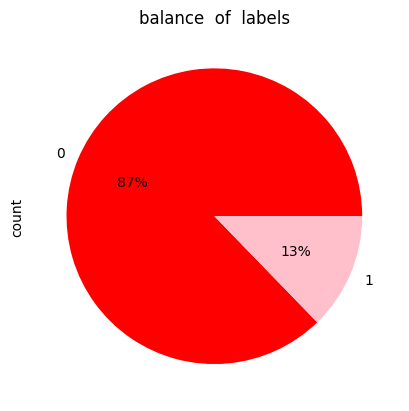

In [107]:
train['label'].value_counts().plot.pie( autopct='%1.0f%%',
 colors = ['red', 'pink'],
 title='balance  of  labels')

<Axes: title={'center': 'balance  of  labels'}, ylabel='count'>

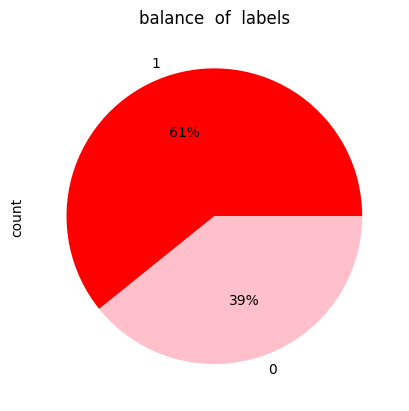

In [108]:
test['label'].value_counts().plot.pie( autopct='%1.0f%%',
 colors = ['red', 'pink'],
 title='balance  of  labels')

In [109]:
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

In [110]:
data = DatasetDict()

data['train'] = train
data['validation'] = test 

In [111]:
from transformers import AutoTokenizer
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/957 [00:00<?, ? examples/s]

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

In [79]:
from huggingface_hub import notebook_login

notebook_login()

In [112]:
import torch
device = torch.device("cpu")

In [120]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
from transformers import TrainingArguments , Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch"   )
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [121]:
import numpy as np
import evaluate


metric = evaluate.load("accuracy")

In [122]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [123]:
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
)

In [124]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.110777,0.984000
2,No log,0.093669,0.984000
3,No log,0.090648,0.984000


TrainOutput(global_step=360, training_loss=0.06497510274251302, metrics={'train_runtime': 185.2952, 'train_samples_per_second': 15.494, 'train_steps_per_second': 1.943, 'total_flos': 755391839938560.0, 'train_loss': 0.06497510274251302, 'epoch': 3.0})

In [125]:
from transformers import TextClassificationPipeline

model = model.to(device)
tokenizer = tokenizer
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

In [126]:
pipe('''Dear makronald8@gmail.com,

We have received your request and someone will be looking into this.

We are very busy at the moment, so please bear with us. We are committed to resolving every ticket as promptly as possible, and we encourage you to let us know if you have any additional concerns or questions. To reply to this message please log into your account via our mobile app then go to your account area in the bottom menu and then to the manage tickets option. Alternatively you can login via our website and go to your "my account" area then selecting the support area.

You will receive a message from the team when any action has been taken on your ticket, this will also be available in your tickets and support area on our app and website.

We do try to respond to some queries automatically, if you have received a response already from the team please ignore this message.
''')

[[{'label': 'LABEL_1', 'score': 0.9979150891304016},
  {'label': 'LABEL_0', 'score': 0.002084854757413268}]]